# Imports & necessary functions

In [ ]:
! pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
! pip install text_flappy_bird_gym

In [17]:
import os, sys
import gym
import time
import text_flappy_bird_gym
import IPython
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from text_flappy_bird_gym.envs.text_flappy_bird_env_simple import TextFlappyBirdEnvSimple
from text_flappy_bird_gym.envs.text_flappy_bird_env_screen import TextFlappyBirdEnvScreen
from text_flappy_bird_gym.envs.text_flappy_bird_logic import FlappyBirdLogic
import agent
from scipy.stats import sem
#BASE LINE
from IPython import display
import pylab as pl
import matplotlib
import pandas as pd
import seaborn as sns

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# from agents.baselineAgent import BaselineAgent
# from agents.SARSAAgent import SARSAAgent

## Important classes and functions

In [18]:
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

In [19]:
from collections import defaultdict
class QLearningFlappy():
    def agent_init(self, agent_init_info):
        """
        The Q-Learning agent
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions: The number of actions,
            epsilon: The exploration parameter,
            eps_decay: The decay rate of the epsilon,
            step_size: The step-size (learning rate),
            step_size_decay: The decay rate of the step-size,
            discount: The discount factor,   
        }
        
        """

        # Store the parameters provided in agent_init_info
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.eps_decay = agent_init_info["eps_decay"]
        self.step_size = agent_init_info["step_size"]
        self.step_size_decay = agent_init_info["step_size_decay"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        
        # Create a dictionary for action-value estimates
        self.q = defaultdict(float)



    def agent_start(self, state):
        """
        To start the agent.
        
        Args:
            state: the state from the
                environment's evn_start function.
        Returns:
            action : the first action the agent takes.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action

        return action


    def agent_step(self, reward, state):
        """
        To make a step for the agent.
        Args:
            reward: the last received reward (from last action)
            state: state the agent is after receiving 'reward'
        Returns:
            action: the action the agent is taking.
        """
        current_q = [self.q[(state, 0)], self.q[(state, 1)]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        Qsa_next = np.max(current_q)
        # self.q[(self.prev_state, self.prev_action)] += self.step_size*(reward + self.discount*Qsa_next\
        #     - self.q[(self.prev_state, self.prev_action)])
        self.q[(self.prev_state, self.prev_action)] += self.step_size*(reward + self.discount*Qsa_next\
            - self.q[(self.prev_state, self.prev_action)])

        
        self.prev_state = state
        self.prev_action = action

        self.step_size = max(self.step_size * self.step_size_decay, 0.1) 
        self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 

        
        return action


    

    def agent_end(self, reward):
        """To run when the agent is finished (dies).
        Args:
            reward: the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        Qsa_next = 0
        self.q[(self.prev_state, self.prev_action)] += self.step_size*(reward + self.discount*Qsa_next\
            - self.q[(self.prev_state, self.prev_action)])

    def argmax(self, q_values):
        """
        argmax with random tie-breaking
        Args:
            q_values: the array of action-values
        Returns:
            action: an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [20]:
q = defaultdict(lambda x: 0)

In [21]:
class SARSAFlappy():
    def agent_init(self, agent_init_info):
        """
        The Q-Learning agent
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions: The number of actions,
            epsilon: The exploration parameter,
            eps_decay: The decay rate of the epsilon,
            step_size: The step-size (learning rate),
            step_size_decay: The decay rate of the step-size,
            discount: The discount factor,   
        }
        
        """

        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.eps_decay = agent_init_info["eps_decay"]
        self.step_size = agent_init_info["step_size"]
        self.step_size_decay = agent_init_info["step_size_decay"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Create a dictionary for action-value estimates
        # self.q = defaultdict(float)
        # self.q = {}
        # for x in range(14):
        #     for y in range(-12,22+1):
        #         self.q[((x,y), 1)] = 0
        #         self.q[((x,y), 0)] = 0
        self.q = defaultdict(float)

        
    def agent_start(self, state):
        """
        To start the agent.
        
        Args:
            state: the state from the
                environment's evn_start function.
        Returns:
            action : the first action the agent takes.
        """
        
        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        
        self.prev_state = state
        self.prev_action = action

        
        return action
    
    def agent_step(self, reward, state):
        """
        To make a step for the agent.
        Args:
            reward: the last received reward (from last action)
            state: state the agent is after receiving 'reward'
        Returns:
            action: the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = [self.q[(state, 0)], self.q[(state, 1)]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        

        current = self.q[(self.prev_state, self.prev_action)]         # estimate in Q-table (for current state, action pair)
        policy_s = np.ones(self.num_actions) * self.epsilon / self.num_actions  # current policy (for next state S')
        policy_s[self.argmax(current_q)] = 1 - self.epsilon + (self.epsilon / self.num_actions) # greedy action
        Qsa_next = np.dot(current_q, policy_s)         # get value of state at next time step
        self.q[(self.prev_state, self.prev_action)]  = current + self.step_size*(reward + (self.discount * Qsa_next)  - current )          # construct target
  
        
        self.prev_state = state
        self.prev_action = action

        self.step_size = max(self.step_size * self.step_size_decay, 0.1) 
        self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 
        
        return action
    
    def agent_end(self, reward):
        """
        To run when the agent is finished (dies).
        Args:
            reward: the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        current = self.q[(self.prev_state, self.prev_action)]  # estimate in Q-table (for current state, action pair)
        Qsa_next = 0    
        self.q[(self.prev_state, self.prev_action)]  = current + self.step_size*(reward + (self.discount * Qsa_next)  - current)          # construct target

        
    def argmax(self, q_values):
        """
        argmax with random tie-breaking
        Args:
            q_values: the array of action-values
        Returns:
            action: an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [22]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_policy(q):
    """
    Plot the policy basedd on q. policy will be the argmax for each state 
    Args:
        q = state-value function
    """
    def get_policy(x, y):
        return argmax([q[((x,y),0)], q[((x,y),1)]])

    def get_figure(ax):
        x_range = np.arange(0, 14)
        # y_range = np.arange(10, 0, -1)
        y_range = np.arange(-12,22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_policy(x,y) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[0, 14, -11, 22])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('horizontal distance')
        ax.set_ylabel('Vertical distance')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (FALL)','1 (JUMP)'])
            
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ax = fig.add_subplot(111)
    ax.set_title('Flappy bird policy')
    get_figure(ax)
    ax.invert_yaxis()

    plt.show()

In [23]:
def run_agent_analysis(agent, agent_info, env, num_runs, num_episodes, plot=True, rolling=15):
    """
    Function to run the agent annalyis.
    Args:
        agent: the agent 
        agent_info: its init information (epsilon, discount, ...)
        env: the environnment
        num_runs: the total number of run to calculate
        num_episode: the number of episode for each run (the action)
        plot (bool): whether to plot the final results
        rolling: size of the rolling-window to display
    """

    all_reward_sums = [] # Contains sum of rewards during episode
    all_state_visits = [] # Contains state visit counts during the last 10 episodes
    all_scores = [] # Contains the scores obtained for each run
    agent_info["seed"] = 0
    agent.agent_init(agent_info)

    env_info = {}
    
    # Iteration over the number of runs
    for run in range(num_runs):
        # Set the seed value to the current run index
        agent_info["seed"] = run

        # Initialize the environment
        # state = env.reset()

        # Set done to False
        done = False

        reward_sums = []
        state_visits = defaultdict(float)

        # Iterate over the number of episodes
        for episode in range(num_episodes):
            # print(episode, done, reward_sums)
            if not done:
                if episode == 0:
                    # print('first episode')
                    # Keep track of the visited states
                    state = env.reset()[0]
                    action = agent.agent_start(state)

                    state_visits[state] = 1
                    state, reward, done,_, info = env.step(action)
                    reward_sums.append(reward)

                else:
                    action = agent.agent_step(reward, state)
                    # agent.epsilon = agent.epsilon * agent.eps_decay
                    state_visits[state] += 1

                    state, reward, done,_, info = env.step(action)
                    reward_sums.append(reward)

            # If terminal state
            elif done:
                action = agent.agent_end(reward)
                break
            # print('ca break')

        all_reward_sums.append(np.sum(reward_sums))
        all_state_visits.append(state_visits)
        all_scores.append(info["score"])
        # print('run ', run, np.sum(reward_sums), all_reward_sums)
        # print(all_reward_sums)
    
    df_rewards = pd.DataFrame(columns=['run', 'reward_sum', f'rolling_{rolling}_avg'])
    df_rewards.run = np.arange(num_runs)
    df_rewards.reward_sum = all_reward_sums
    df_rewards[f'rolling_{rolling}_avg'] = df_rewards.reward_sum.rolling(rolling).mean()

    if plot:
        pd.DataFrame(columns=[])
        print(max(all_reward_sums))
        x = np.arange(num_runs)
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df_rewards, x='run', y='reward_sum', label='reward sum', alpha=0.7)
        sns.lineplot(data=df_rewards, x='run', y=f'rolling_{rolling}_avg', label=f'rolling {rolling}-run average', color='red')
        plt.xlabel("Run")
        plt.ylabel("cumulated reward")
        plt.title(f'Cumulated reward for {agent.__class__.__name__}')
        plt.ylim(0,max(max(all_reward_sums),100))
        plt.ioff()
        plt.show()
    
    return df_rewards, all_state_visits, all_scores

In [24]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_surface(V, X, Y, Z, title):

        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=min(V.values()), vmax=max(V.values()))
        ax.set_xlabel('Horizontal distance')
        ax.set_ylabel('Vertical distance')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()


def plot_value_function(V, title="Flappy value func"):
    """
    Plots the value function as a surface plot.
    qValue: if True = plot qValue else only Value
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
  
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))
    plot_surface(V, X, Y, Z, "{}".format(title))



def plot_Q_value_function(V, title="Flappy value func"):

      min_x = min(k[0][0] for k in V.keys())
      max_x = max(k[0][0] for k in V.keys())
      min_y = min(k[0][1] for k in V.keys())
      max_y = max(k[0][1] for k in V.keys())

      x_range = np.arange(min_x, max_x + 1)
      y_range = np.arange(min_y, max_y + 1)
      X, Y = np.meshgrid(x_range, y_range)
        
      Z_jump = np.apply_along_axis(lambda _: V[((_[0], _[1]),1)], 2, np.dstack([X, Y]))
      Z_still = np.apply_along_axis(lambda _: V[((_[0], _[1]),0)], 2, np.dstack([X, Y]))
      plot_surface(V, X, Y, Z_jump, "{}: jumping".format(title))
      plot_surface(V, X, Y, Z_still, "{}: still".format(title))

# Q learning class

107


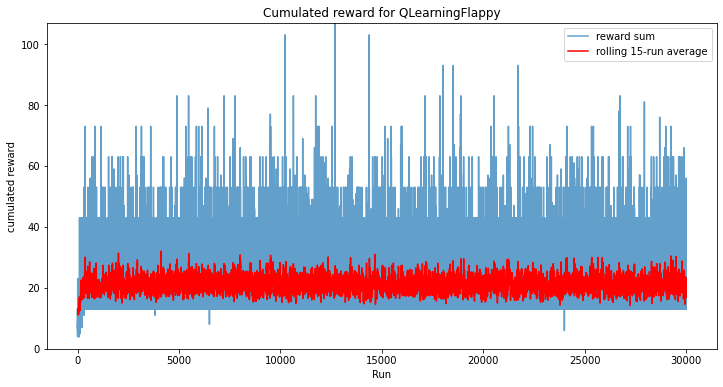

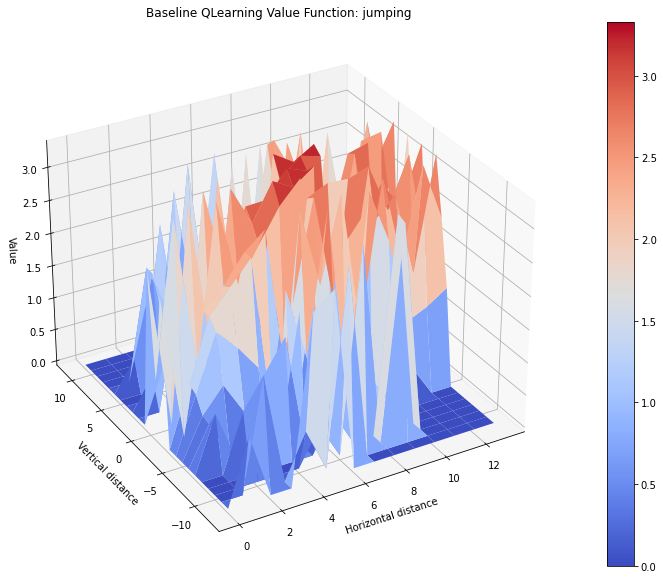

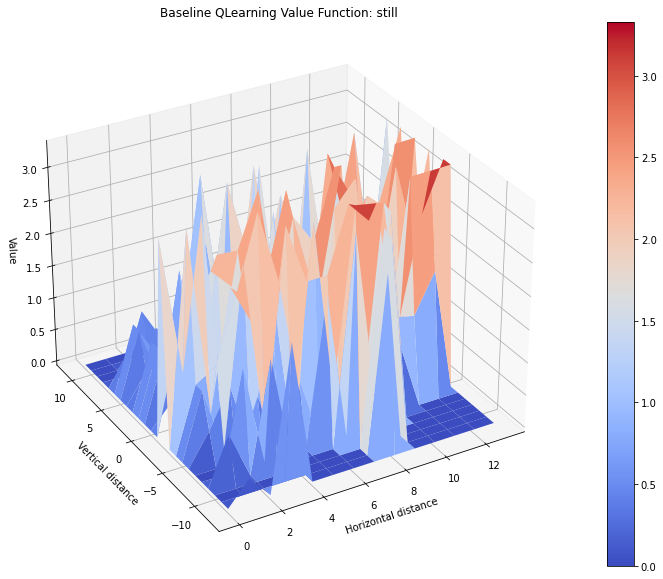

In [25]:
#BASE LINE
agent = QLearningFlappy()
env = TextFlappyBirdEnvSimple()
agent_info = {"num_actions": 2,
            "epsilon": 0.8,
            "eps_decay":.999,
            "step_size": 0.5,
            "step_size_decay": 0.9999,
            "discount": 0.7}
all_reward_sums, all_state_visits, all_scores = run_agent_analysis(agent, agent_info, env, num_episodes=1000, num_runs=30000)
plot_Q_value_function(agent.q, title="Baseline QLearning Value Function")


# Expected SARSA Class

143


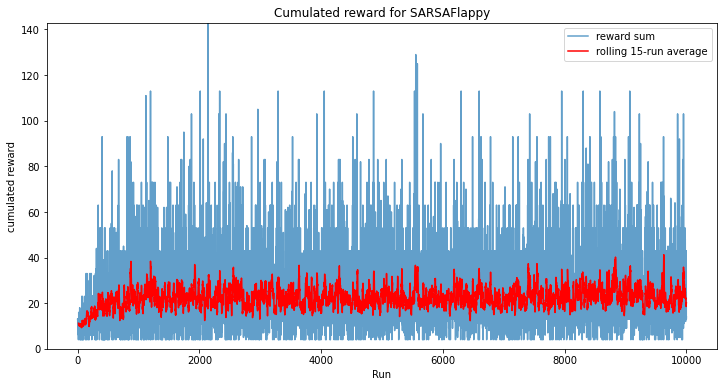

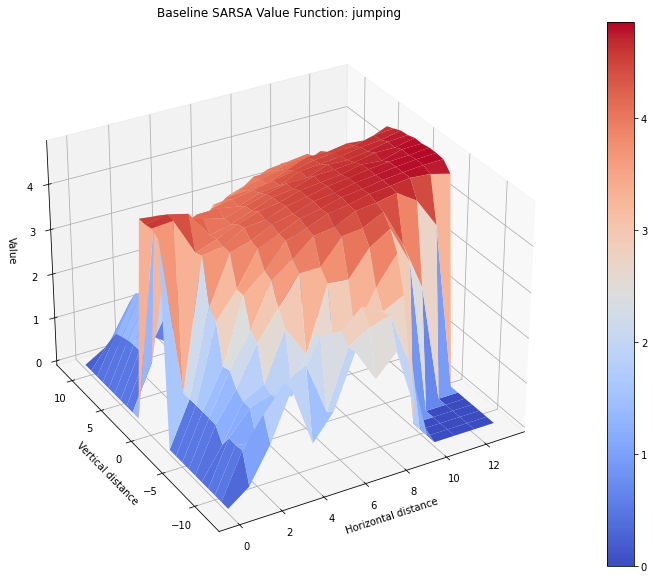

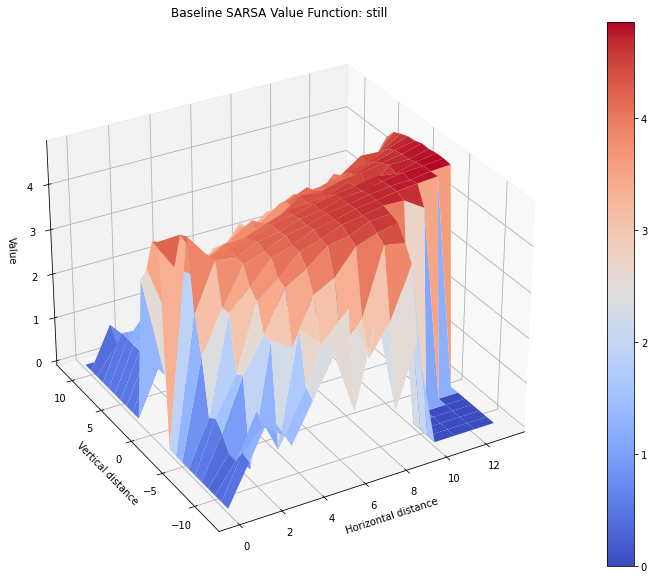

In [22]:
#BASE LINE
agent = SARSAFlappy ()
env = TextFlappyBirdEnvSimple()
agent_info = {"num_actions": 2,
            "epsilon": 0.5,
            "eps_decay":1,
            "step_size": 0.5,
            "step_size_decay": 0.9999,
            "discount": 0.8}
all_reward_sums, all_state_visits, all_scores = run_agent_analysis(agent, agent_info, env, num_episodes=500, num_runs=10000)
plot_Q_value_function(agent.q, title="Baseline SARSA Value Function")

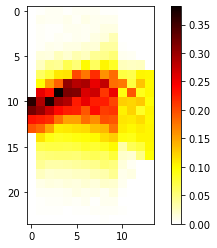

In [23]:
##########################################
### STATES VISITED DURING THE TRAINING  ##
##########################################
matrix = np.zeros((25, 23))
# Loop over each dictionary and add its values to the matrix
xs = []
ys = []
for d in all_state_visits:
    for key, value in d.items():
        x, y = key
        xs.append(x)
        ys.append(y)

max_x, min_x = max(set(xs)), min(set(xs)) 
max_y, min_y = max(set(ys)), min(set(ys)) 
matrix = np.zeros((max_x - min_x + 1, max_y - min_y + 1))


for d in all_state_visits:
    for key, value in d.items():
        x, y = key
        matrix[x][(y-min_y)] += value
# Divide each element in the matrix by the number of dictionaries to get the average
matrix /= len(all_state_visits)

# Plot the heatmap
plt.imshow(matrix.T, cmap='hot_r', interpolation='nearest')
plt.colorbar()
# plt.yticks(list(set(ys)))
plt.show()

# Comparison

In [26]:

def parameter_influence(param_name, param_values, agent_info, plot=True):
    """
    Function to compare the agents' behaviour on a given parameter evolution
    Args:
        param_name: the parameter name to try
        param_values: list of values of the parameter
        agent_info: the baseline agent info
        plot: whether to plot the results
    """
    agents = {
    "Q-learning": QLearningFlappy(),
    "Expected Sarsa": SARSAFlappy()
}

    
    all_reward_sums = {}

    for algorithm in ["Q-learning", "Expected Sarsa"]:
        for param_val in tqdm(param_values):
            env = TextFlappyBirdEnvSimple()
            agent_info[param_name] = param_val
            agent = agents[algorithm]
            all_reward_sums_agent, _, _ = run_agent_analysis(agent, agent_info, env, num_episodes=600, num_runs=500, plot=False)

            #take the last 50 runs 
            all_reward_sums[(algorithm, param_val)] = all_reward_sums_agent.reward_sum[-50:]

    if plot:
        for algorithm in ["Q-learning", "Expected Sarsa"]:
            algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, param_val)]) for param_val in param_values])
            algorithm_stds = np.array([sem(all_reward_sums[(algorithm, param_val)]) for param_val in param_values])
            plt.plot(param_values.round(3), algorithm_means, marker='o', linestyle='solid', label=algorithm)
            plt.fill_between(param_values, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

        plt.legend()
        plt.xlabel(f"{param_name}")
        plt.ylabel("Average final reward run")#,rotation=0, labelpad=50)
        plt.title(f'{param_name}: Average final reward (last 50 run of training)')
        plt.xticks(param_values)
        plt.xticks(rotation=90)
        # plt.ylim(0,100)
        
        plt.show()
    return all_reward_sums

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


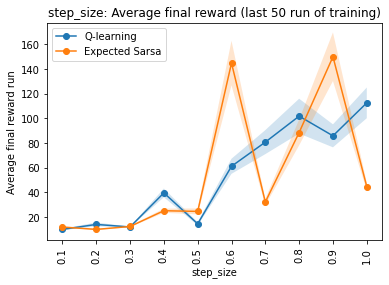

In [123]:
agent_info = {"num_actions": 2,
                "epsilon": 0.8,
                "eps_decay":.999,
                "step_size":0.5,
                "step_size_decay": 0.9999,
                "discount": 1.0}
rew_step_size = parameter_influence('step_size', np.linspace(0.1,1.0,10), agent_info, plot=True)

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


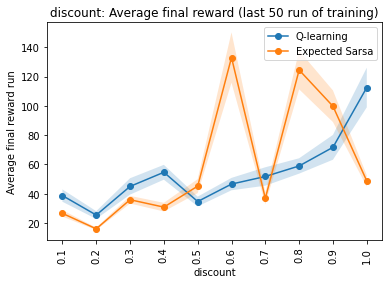

In [124]:
agent_info = {"num_actions": 2,
                "epsilon": 0.8,
                "eps_decay":.999,
                "step_size":0.9,
                "step_size_decay": 0.9999,
                "discount": 0.8}
reward_discount = parameter_influence('discount', np.linspace(0.1,1.0,10), agent_info, plot=True)

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


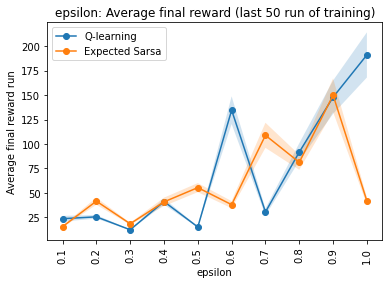

In [125]:
agent_info = {"num_actions": 2,
                "epsilon": 0.8,
                "eps_decay":.999,
                "step_size":0.9,
                "step_size_decay": 0.9999,
                "discount": 0.7}
reward_epsilon = parameter_influence('epsilon', np.linspace(0.1,1.0,10), agent_info, plot=True)

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


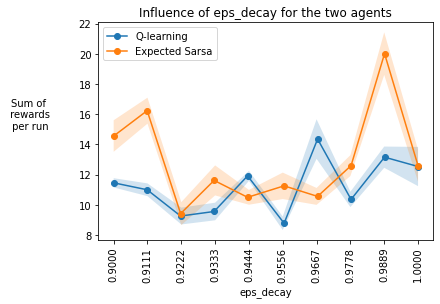

In [60]:
agent_info = {"num_actions": 2,
                "epsilon": 0.8,
                "eps_decay":.999,
                "step_size":0.8,
                "step_size_decay": 0.9999,
                "discount": 0.71}
reward_epsilon = parameter_influence('eps_decay', np.linspace(0.9,1.0,10), agent_info, plot=True)

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


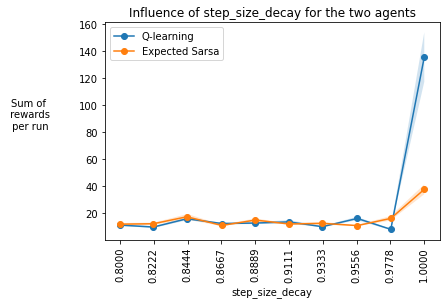

In [59]:
agent_info = {"num_actions": 2,
                "epsilon": 0.8,
                "eps_decay":.999,
                "step_size":0.8,
                "step_size_decay": 0.9999,
                "discount": 0.71}
reward_epsilon = parameter_influence('step_size_decay', np.linspace(0.8,1.0,10), agent_info, plot=True)

# Best agents comparison

133


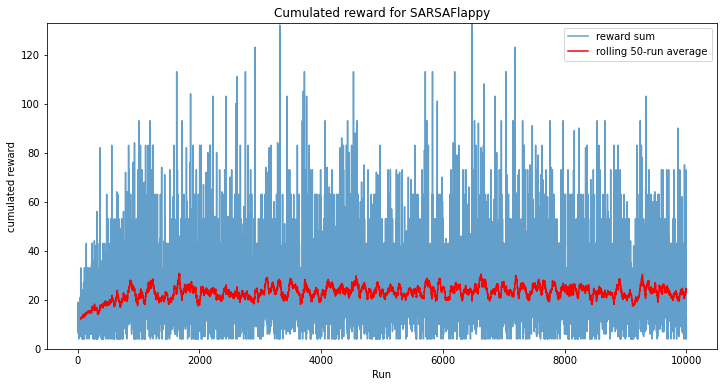

In [33]:
sarsa_agent_info = {"num_actions": 2,
            "epsilon": 0.5,
            "eps_decay":1,
            "step_size": 0.5,
            "step_size_decay": 0.9999,
            "discount": 0.8}
best_sarsa = SARSAFlappy()
env = TextFlappyBirdEnvSimple()
sarsa_df, b, c = run_agent_analysis(best_sarsa, sarsa_agent_info, env, num_episodes=600, num_runs=10000, plot=True, rolling=50)

124


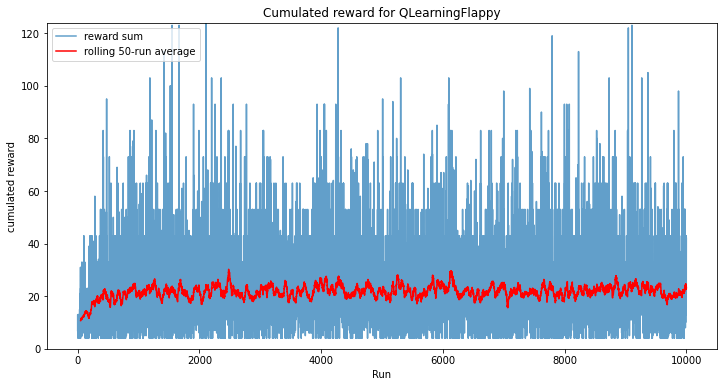

In [27]:
q_agent_info = {"num_actions": 2,
            "epsilon": 0.5,
            "eps_decay":1,
            "step_size": 0.5,
            "step_size_decay": 0.9999,
            "discount": 0.8}
best_q = QLearningFlappy()
env = TextFlappyBirdEnvSimple()
q_df, b, c = run_agent_analysis(best_q, q_agent_info, env, num_episodes=600, num_runs=10000, plot=True, rolling=50)

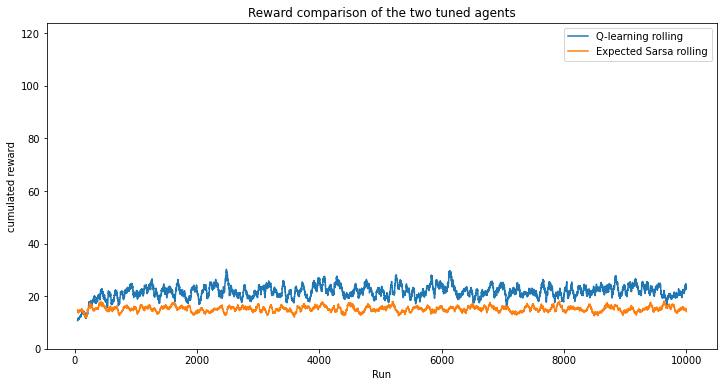

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=q_df, x='run', y=f'rolling_{50}_avg', label='Q-learning rolling')
sns.lineplot(data=sarsa_df, x='run', y=f'rolling_{50}_avg', label='Expected Sarsa rolling')
plt.xlabel("Run")
plt.ylabel("cumulated reward")
plt.title(f'Reward comparison of the two tuned agents')
plt.ylim(0,max(max(q_df.reward_sum),40))
plt.ioff()
plt.show()

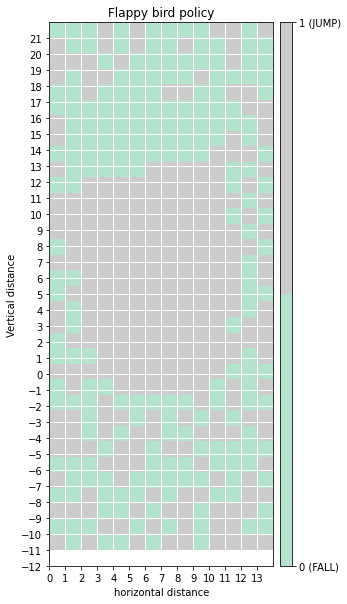

In [30]:
plot_policy(best_q.q)

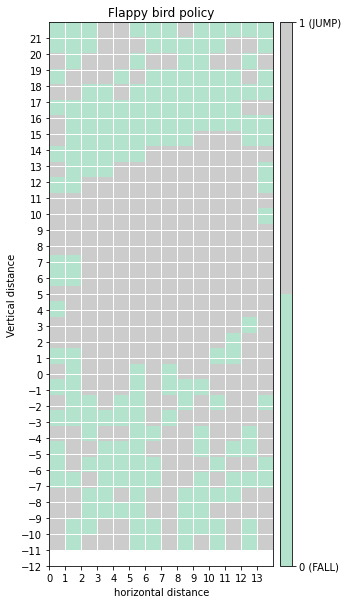

In [34]:
plot_policy(best_sarsa.q)